# TinyMind多标签图像分类

### 1 题目介绍

  训练一个多标签分类模型，使得该模型能自动根据输入的任意图像提供对应图片内容的多个标签

### 2 数据集介绍

 本次竞赛共有3.5W张图片作为训练集，8K张图片作为第一阶段评分测试集，最后6612张图片作为总决赛测试集。
 
  - viual_china_train.csv：图片与标签对应的列表。
  - valid_tags.txt: 6941个标签的有序列表文件。
  - tags_train.npz: 3.5W张图片对应的标签
  - train.tgz: 3.5W张训练图片
  - valid.tgz: 8K验证图片

### 3 思路

如猫狗大战的二分类、cifar-10的多分类，本次题目是多标签的图像分类，每张图片可能没有标签页可能存在6941个标签，即各个标签之间是不存在互斥关系的，所以最终分类的损失函数不能用softmax而必须要用sigmoid。然后把分类层预测6941个神经元，每个神经元用sigmoid函数返回是否存在某个标签即可。

### 4 具体流程

In [1]:
# 导入模块
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

In [2]:
# 存放地址
dir_path = "D:\\01\\01contest"
print(os.listdir(dir_path))

['tag_train.npz', 'train', 'train.tar', 'train.tgz', 'valid', 'valid.tar', 'valid.tgz', 'valid_tags.txt', 'visual_china_train.csv']


**（1）获取数据和标签**

先导入train_csv的数据，保存文件名以及标签名。

In [3]:
# 查看数据
train_path = os.path.join(dir_path,"visual_china_train.csv")
train_df = pd.read_csv(train_path)
train_df.head()

,img_path,tags
0,2074d1cd049f38bb42198e18b23c0443230afb68.jpg,"办公室,白昼,隔断,无人,加利福尼亚,商务,窗户,留白,图像,摄影,公司企业,开放式设计,圣..."
1,40591a781c7a3af93232a83dc2e1665d38b772bf.jpg,"青年人,休闲,白昼,知识,美,树,学校,凝视,时间,衣服,中国人,微笑,表现积极,青年女人,..."
2,d41f7b535f13c15802aa393bc41d2b257992faee.jpg,"想望,美术肖像,尤物,仅一个女人,调情,白人,美人,魅力,微笑,青年女人,女人,信心,美女,..."
3,f7ecc1a8182256885efce7edd40bfd84be6f05fb.jpg,"运动鞋,休闲,运动服,风景,白昼,在活动中,浪漫,家庭,树,动态动作,享乐,马勒,骑马,中国..."
4,09574a46403ab85188404d9383fe7fff51fac3a7.jpg,"灰色,静物,垂直画幅,打结,室内,商务,领带,无人,捕获的,捕获的"


In [4]:
print(train_df.shape)

(35000, 2)


处理图片名称，将其保存到img_paths列表中

In [5]:
img_paths = list(train_df["img_path"])

验证图片标签是否的确只有6941个标签

In [6]:
tags = []
for i in range(train_df["tags"].shape[0]):
    for tag in train_df["tags"].iloc[i].split(","):
        tags.append(tag)
        
tags = set(tags)
print("the length of tags:",len(tags))

the length of tags: 6941


前期准备工作差不多做完了，开始导入训练集。原始训练集中存在CMYK格式的图片，传统图片处理一般格式为RGB格式，所以我们使用Image库中的convert函数对非RGB格式的图片进行转换。

In [7]:
# 尝试少量数据验证模型
num_train = 5000
X_train = np.zeros((num_train,224,224,3),dtype=np.uint8)
i = 0
for img_path in img_paths[:num_train]:
    img = Image.open(dir_path + "/train/" + img_path)
    if img.mode!="RGB":
        img = img.convert("RGB")
    img = img.resize((224,224))
    arr = np.asarray(img)
    X_train[i,:,:,:] = arr
    i += 1

训练集导入完成，查看一下图片的样子

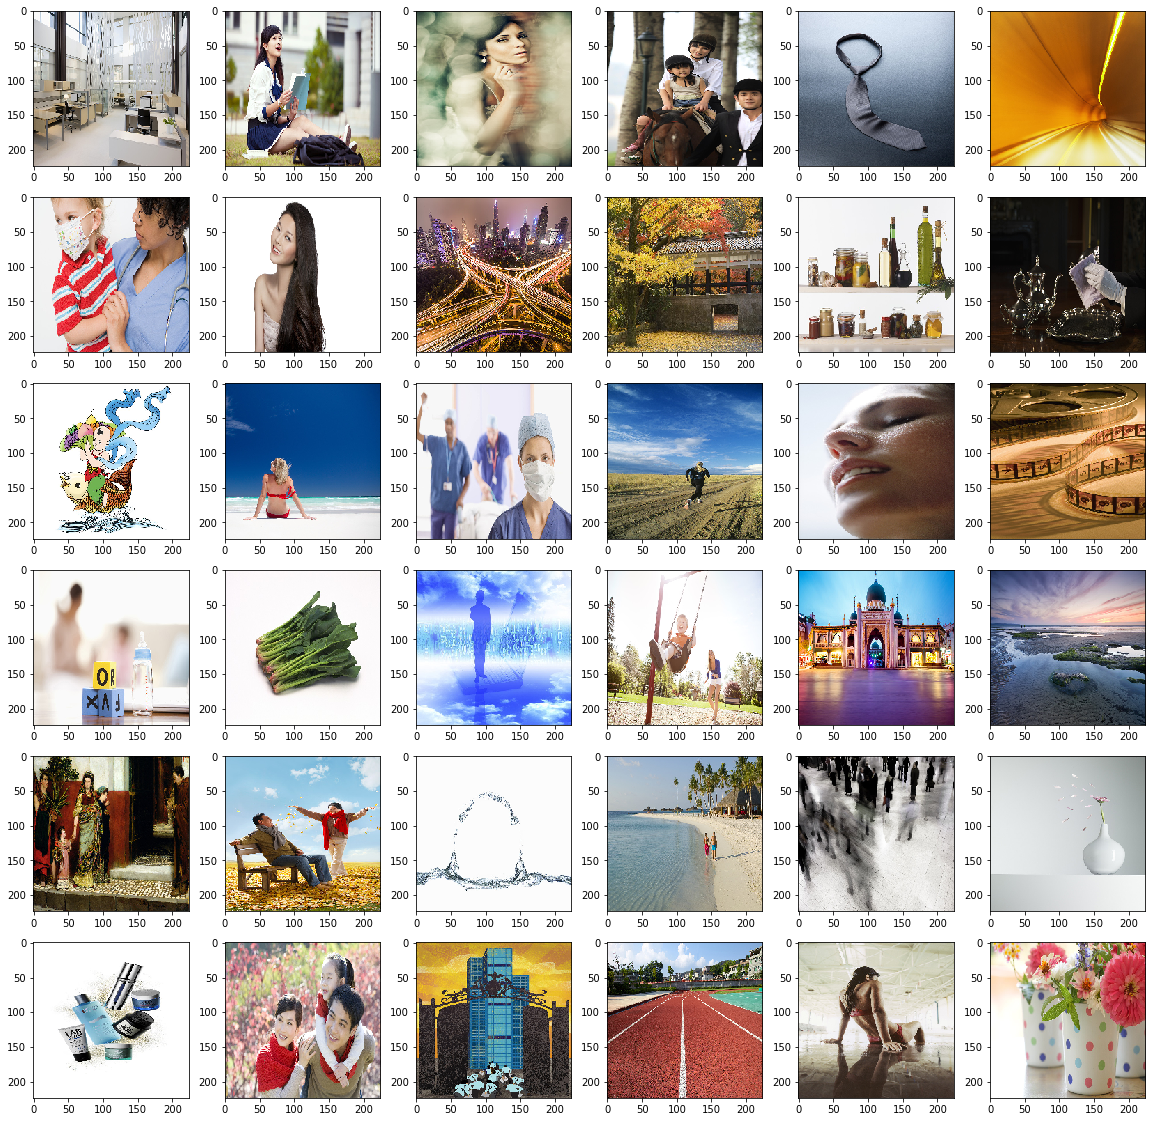

In [8]:
fig,axes = plt.subplots(6,6,figsize=(20,20))

j = 0
for i,img in enumerate(X_train[:36]):
    axes[i//6,j%6].imshow(img)
    j+=1

准备标签

In [9]:
y_train_path = os.path.join(dir_path,"tag_train.npz")
y_train = np.load(y_train_path)

In [10]:
y_train.files

['tag_train']

In [11]:
y_train = y_train["tag_train"]
y_train.shape

(35000, 6941)

这样，数据和标签都拿到了，这里还是要是要分割一下数据集的。

In [12]:
from sklearn.model_selection import train_test_split
X_train2,X_val,y_train2,y_val = train_test_split(X_train,y_train[:num_train],test_size=0.2,random_state=2019)

In [13]:
print(X_train2.shape)
print(y_train2.shape)
print(X_val.shape)
print(y_val.shape)

(4000, 224, 224, 3)
(4000, 6941)
(1000, 224, 224, 3)
(1000, 6941)


**(2)模型搭建**

这里直接迁移模型，用ResNet模型进行迁移

In [14]:
# 导入开发需要的库
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.applications import *

Using TensorFlow backend.


In [15]:
base_model = ResNet50(input_tensor=Input((224,224,3)),weights="imagenet",include_top=False)

for layers in base_model.layers:
    layers.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(6941,activation="sigmoid")(x)
model = Model(base_model.input,x)

W0819 19:49:36.277899 16092 deprecation_wrapper.py:119] From D:\software\Anaconda\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 19:49:36.413536 16092 deprecation_wrapper.py:119] From D:\software\Anaconda\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 19:49:36.419520 16092 deprecation_wrapper.py:119] From D:\software\Anaconda\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0819 19:49:36.448443 16092 deprecation_wrapper.py:119] From D:\software\Anaconda\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 19:49:36.450437 160

**监测精准率 召回率 和F1的功能函数**

In [16]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)


**数据增强操作**

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1)
val_datagen = ImageDataGenerator() # 验证集不做图片增强

batch_size = 4

train_generator = train_datagen.flow(X_train2,y_train2,batch_size=batch_size,shuffle=False)
val_generator = val_datagen.flow(X_val,y_val,batch_size=batch_size,shuffle=False)

**（3）模型训练**

` keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=False, save_weights_only=False, mode='auto', period=1) `
  
  - filename：字符串，保存模型的路径（可以将模型的准确率和损失等写到路径中，格式如下：）
  - monitor:需要检测的值如测试集损失或者训练集损失等
  - save_best_only：当设置为True时，监测值有改进时才会保存当前的模型
  - verbose：信息展示模式，0或1（当为1时会有如下矩形框的信息提示）
  - mode：‘auto’，‘min’，‘max’之一，在save_best_only=True时决定性能最佳模型的评判准则，例如，当监测值为val_acc时，模式应为max，当监测值为val_loss时，模式应为min。在auto模式下，评价准则由被监测值的名字自动推断。
  - save_weights_only：若设置为True，则只保存模型权重，否则将保存整个模型
  - period：CheckPoint之间的间隔的epoch数
 
` keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)`
 
   - 当评价指标不在提升时，减少学习率
   - monitor：被监测的量
   - factor：每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
   - patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
   - mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
   - epsilon：阈值，用来确定是否进入检测值的“平原区”
   - cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
   - min_lr：学习率的下限

In [18]:
checkpointer = ModelCheckpoint(filepath='weights_best_simple_model.hdf5', 
                            monitor='val_fmeasure',verbose=1, save_best_only=True, mode='max')
reduce = ReduceLROnPlateau(monitor='val_fmeasure',factor=0.5,patience=2,verbose=1,min_delta=1e-4,mode='max')

model.compile(optimizer = 'adam',
           loss='binary_crossentropy',
           metrics=['accuracy',fmeasure,recall,precision])

epochs = 5

W0819 19:50:33.499524 16092 deprecation_wrapper.py:119] From D:\software\Anaconda\anaconda\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 19:50:34.978711 16092 deprecation.py:323] From D:\software\Anaconda\anaconda\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
history = model.fit_generator(train_generator,
                             validation_data=val_generator,
                             steps_per_epoch=num_train/batch_size,
                             validation_steps = num_train/batch_size,
                             epochs=epochs,
                             callbacks=[checkpointer,reduce],
                             verbose=1)

Epoch 1/5
1250/1250 [==============================] - 184s 147ms/step - loss: 0.0261 - acc: 0.9942 - fmeasure: 0.2471 - recall: 0.1591 - precision: 0.6219 - val_loss: 0.0292 - val_acc: 0.9937 - val_fmeasure: 0.3037 - val_recall: 0.2469 - val_precision: 0.4238

Epoch 00001: val_fmeasure improved from -inf to 0.30369, saving model to weights_best_simple_model.hdf5
Epoch 2/5
1250/1250 [==============================] - 174s 139ms/step - loss: 0.0206 - acc: 0.9947 - fmeasure: 0.3055 - recall: 0.2082 - precision: 0.6200 - val_loss: 0.0331 - val_acc: 0.9925 - val_fmeasure: 0.2999 - val_recall: 0.2889 - val_precision: 0.3276

Epoch 00002: val_fmeasure did not improve from 0.30369
Epoch 3/5
1250/1250 [==============================] - 175s 140ms/step - loss: 0.0177 - acc: 0.9949 - fmeasure: 0.3544 - recall: 0.2518 - precision: 0.6386 - val_loss: 0.0367 - val_acc: 0.9914 - val_fmeasure: 0.2670 - val_recall: 0.2813 - val_precision: 0.2662

Epoch 00003: val_fmeasure did not improve from 0.30369


以上就是5000张图片的简单模型训练过程。

**（4）模型保存**

In [20]:
model.save("model.h5")

**（5）模型预测**

In [21]:
predict_path = os.path.join(dir_path,"valid")
predict_img_paths = os.listdir(predict_path)
predict_num = len(predict_img_paths)
print(predict_num)

8000


导入测试集

In [24]:
model.load_weights("weights_best_simple_model.hdf5")

In [25]:
X_test = np.zeros((predict_num,224,224,3),dtype=np.uint8)
i = 0
for img_path in predict_img_paths:
    img = Image.open(predict_path + "\\" + img_path)
    if img.mode!="RGB":
        img = img.convert("RGB")
    img = img.resize((224,224))
    arr = np.asarray(img)
    X_test[i,:,:,:] = arr
    i += 1

预测测试集并将结果转为中文标签，以便生成提交文件。

In [26]:
y_pred = model.predict(X_test)

In [27]:
print(y_pred.shape)
y_pred[0]

(8000, 6941)


array([3.2395124e-05, 0.0000000e+00, 2.0861626e-07, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [28]:
# 将预测结果转换为中文标签

# 第一步  形成索引和标签的字典 
def hash_tag(filepath):
    f = open(filepath,"r",encoding="utf-8")
    hash_tag = {}
    i = 0
    for line in f.readlines():
        line = line.strip()
        hash_tag[i] = line
        i += 1
    return hash_tag
filepath = os.path.join(dir_path,"valid_tags.txt")
hash_tag = hash_tag(filepath)

# 第二步将结果转为中文标签
def arr2tag(arr):
    tags = []
    for i in range(arr.shape[0]):
        tag = []
        index = np.where(arr[i]>0.5)
        index = index[0].tolist()
        tag = [hash_tag[j] for j in index]
        tags.append(tag)
    return tags
y_tags = arr2tag(y_pred)

In [29]:
print(y_tags[0])

['20多岁', '一个人', '不看镜头', '东亚', '东方人', '亚洲', '亚洲人', '亚洲人和印度人', '人', '仅成年人', '休闲活动', '休闲装', '女性', '幸福', '彩色图片', '微笑', '成年人', '户外', '拿着', '摄影', '放松', '水平画幅', '爱', '生活方式', '男人', '男性', '白昼', '衣服', '青年人']


In [30]:
print(len(y_tags[0]))
print(len(y_tags[1]))

29
30


In [31]:
len(y_tags)

8000

**(5)生成提交文件**

In [32]:
import pandas as pd

df = pd.DataFrame({"img_path":predict_img_paths, "tags":y_tags})
for i in range(df["tags"].shape[0]):
    df["tags"].iloc[i] = ",".join(str(e) for e in  df["tags"].iloc[i])
df.to_csv("submit.csv",index=None)

In [33]:
# 预览一下结果文件
predict_df = pd.read_csv("submit.csv")
predict_df.head()

,img_path,tags
0,000effcf2091ae3895074838b7e5f571186ab362.jpg,"20多岁,一个人,不看镜头,东亚,东方人,亚洲,亚洲人,亚洲人和印度人,人,仅成年人,休闲活..."
1,0014455e5fbfd0961039fe23675debbb1a7b2308.jpg,"20多岁,一个人,东亚,东方人,中国人,亚洲,亚洲人,亚洲人和印度人,人,仅一个女人,仅一个..."
2,002138959ee7a14eb2860100392a384f8a85425f.jpg,"垂直画幅,彩色图片,影棚拍摄,摄影,无人,白色背景"
3,002414411ce17c6c7ab5d36dd3f956d0691ba495.jpg,"东亚,云,人,休闲活动,全身像,地形,天空,度假,彩色图片,户外,摄影,放松,旅游目的地,旅..."
4,002780359fda7f09e6d1fc52d88aff90c6e8298b.jpg,"建筑结构,彩色图片,户外,摄影,放松,无人,树,水,水平画幅,白昼,自然现象,赚钱"
